In [37]:
using LinearAlgebra, NBInclude, IterativeSolvers, FunctionOperators, Printf, Plots, LaTeXStrings

┌ Info: Precompiling LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1278


In [3]:
@nbinclude("helper_functions.ipynb")

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278
┌ Info: Precompiling ToeplitzMatrices [c751599d-da0a-543b-9d20-d0a503d91d24]
└ @ Base loading.jl:1278


rand (generic function with 167 methods)

In [4]:
Random.seed!(123);

### Vanilla MatrixIRLS for matrix completion (PCA) with p = 0

https://mediatum.ub.tum.de/doc/1521436/1521436.pdf

_**Note:** Vanilla = Conjugate gradient step (2.90) is solved directly without reducing the problem to a lower-dimensional projection space._

<span style="color:red"><strong>Problem:</strong> I don't know how should I calculate the solution of the constrained problem of arg $min_x \langle X,W^{k-1}(X)\rangle \text{ s.t. } \Phi(X) = y$ with conjugate gradient.</span>

**Possible solutions:**
- **[Linearly Constrained Least Squares](https://lls.readthedocs.io/en/latest/math.html):** In our case, $$min_x \Vert W^{1/2} x - b \Vert_2 \text{ s.t. } \Phi x = y$$ can be solved as $$\begin{bmatrix} 2 W^{1/2 *} W^{1/2} & \Phi^*\\ \Phi & 0 \end{bmatrix} \begin{bmatrix} x \\ z \end{bmatrix} = \begin{bmatrix} 2 W^{1/2} b \\ y \end{bmatrix},$$ where $z$ is a new variable. This system has a unique solution when the matrix $\Phi$ has independent rows (this is always true for sampling matrices), and the matrix $\begin{bmatrix} A \\ C \end{bmatrix}$ has indepedent columns (I'm not sure if it is always true).
  - *The problem with this approach:*
      - *I don't know how to calculate $W^{1/2}$ because it is not a matrix, but rather a function (see 2.57 on page 73).*
      - *This method requires x to be a vector and $W$ should also be modified accordingly. Again, as $W$ is not a matrix, I have no idea how can I transform $W$ to suit the vectorized problem.*
      - *$b$ is unknown.*
      - *[The only Julia package](https://github.com/davidlizeng/LinearLeastSquares.jl) I found that solves the problem in this way is really outdated, and accepts only matrices.*
- **Augmented Lagrangian and ADMM**
  - *The problem with this approach:*
      - *All of the solvers require $x$ to be a vector and $W$ should also be modified accordingly, but I don't know how it should be done.*
      - *The solvers I found either support multi-variable (i.e. matrix) optimization or deal with general matrix-like/function-like objects like $W$, but I couldn't find any which does both.*

In [5]:
function vanilla_MatrixIRLS_for_PCA(
        Xᴳᵀ::AbstractArray,                     # ground truth for MSE evaluation
        y::AbstractArray,                       # under-sampled data
        Φ::FunctionOperator;                    # sampling operator
        img_size::NTuple = size(Xᴳᵀ),           # size of output matrix
        r̃::Int = 0,                             # rank estimate of solution
        maxIter::Union{Int, Nothing} = nothing, # number of CG iteration steps
        N::Int = 10,                            # number of iterations
        verbose::Bool = false)                  # print rank and loss value in each iteration
    
    # Initialize variables
    dType = eltype(y)
    d₁, d₂ = img_size
    r̃ == 0 && (r̃ = rank(Xᴳᵀ))
    maxIter = maxIter isa Nothing ? r̃*(r̃+d₁+d₂) : maxIter
    ϵᵏ = Inf
    Xᵏ = Φ' * y
    σ = nothing # I just want to make it available outside of the loop
    
    for k in 1:N
"""
    2. Find best rank-(r̃ + 1) approximation of Xᵏ to obtain
        𝒯ᵣ(Xᵏ) = Uᵏ * diag(σᵢᵏ)ᵢ₌₁ʳ * Vᵏ' and σᵣ₊₁ᵏ 
"""
        F = svd(Xᵏ)
        Uᵏ, σ, Vᵏ = F.U[:, 1:r̃], F.S, F.V[:, 1:r̃]
        
"""     update smoothing:                                 (2.91) """
        ϵᵏ = min(ϵᵏ, σ[r̃+1])
        
        r, n, s, e = rank(Xᵏ, atol = 1e-3), opnorm(Xᴳᵀ - Xᵏ, 2), σ[1], ϵᵏ
        n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
        verbose && println("k = $(k-1),\trank(Xᵏ) = $r,\t‖Xᴳᵀ - Xᵏ‖₂ = $n, σ₁ = $s, ϵᵏ = $e")
        
"""
    3. Update Wᵏ as in (2.57), using parameters ϵ = ϵᵏ and p in (2.58) and (2.59), and the
        information Uᵏ , Vᵏ and σ₁ᵏ, ..., σᵣ₊₁ᵏ from item 2.

        (Lines below are based on Remark 2.3.2, the special case for p = 0)
"""
        Hᵏ = [1 / (max(σ[i], ϵᵏ) * max(σ[j], ϵᵏ))  for i in 1:r̃+1, j in 1:r̃+1]
        Wᵏ = FunctionOperator{dType}(name = "Wᵏ", inDims = (d₁, d₂), outDims = (d₁, d₂),
            forw = Z -> Uᵏ * (Hᵏ .* (Uᵏ' * Z * Vᵏ)) * Vᵏ')
        
"""
    1. Use a conjugate gradient method to solve linearly constrained quadratic program
         Xᵏ = arg minₓ ⟨X,Wᵏ⁻¹(X)⟩ s.t. Φ(X) = y         (2.90)
"""
        CG_op = throw(ErrorException("How should I calculate the solution of the constrained problem of " *
                                    "arg minₓ ⟨X,Wᵏ⁻¹(X)⟩ s.t. Φ(X) = y with conjugate gradient?"))
        Xᵏ = cg(CG_op, b, maxiter = maxIter)
    end
    
    r, n, s, e = rank(Xᵏ, atol = 1e-3), opnorm(Xᴳᵀ - Xᵏ, 2), σ[1], ϵᵏ
    n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
    verbose && println("k = $N,\trank(Xᵏ) = $r,\t‖Xᴳᵀ - Xᵏ‖₂ = $n, σ₁ = $s, ϵᵏ = $e")
    
    Xᵏ
end

vanilla_MatrixIRLS_for_PCA (generic function with 1 method)

A slightly different formulation from the draft "Robust PCA by Iteratively Reweighted Least Squares". In the implementation below I followed the instructions from the draft and took the special case when the sparse component is zero.

In [20]:
function vanilla_MatrixIRLS_for_PCA_with_CG(
        Xᴳᵀ::AbstractArray,                     # ground truth for MSE evaluation
        y::AbstractArray,                       # under-sampled data
        Φ::FunctionOperator;                    # sampling operator
        img_size::NTuple = size(Xᴳᵀ),           # size of output matrix
        r̃::Int = 0,                             # rank estimate of solution
        λ::Real,
        maxIter::Union{Int, Nothing} = nothing, # number of CG iteration steps
        N::Int = 10,                            # number of iterations
        verbose::Bool = false)                  # print rank and loss value in each iteration
    
    # Initialize variables
    dType = eltype(y)
    d₁, d₂ = img_size
    r̃ == 0 && (r̃ = rank(Xᴳᵀ))
    maxIter = (maxIter isa Nothing ? r̃*(r̃+d₁+d₂) : maxIter)
    ϵ = Inf
    X₀ = Φ' * y   # that's basically Pᵃ * P(M) as y = P(M)
    X = copy(X₀)
    ΦᵃΦ = Φ' * Φ  # i.e. Pᵃ_Omega * P_Omega
    W = I
    
    r, n, s, e = rank(X, atol = 1e-3), norm(Xᴳᵀ - X), svdvals(X)[1], ϵ
    n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
    verbose && println("k = 0,\trank(X) = $r,\t‖Xᴳᵀ - X‖₂ = $n,\tσ₁ = $s,\tϵ = $e")
    
    for k in 1:N

        # I don't know how to calculate inverses in (29), so I use the equation right after it:
        # ((λ/μ * Wₛ + P' * P) * Wₗ + λ * Wₛ * P' * P)(L) = λ * Wₛ * P' * P(M)
        # Assuming that μ = ∞ and Wₛ = I, that's what I get:
        A = ΦᵃΦ * W + λ * ΦᵃΦ
        b = λ * X₀
        cg!(vec(X), reshape(A, inDims=(d₁*d₂,), outDims=(d₁*d₂,)), vec(b),
            tol=1e-8) # Solve A⋅X = b for X
        
        F = svd(X)
        U, σ, V = F.U, F.S, F.V
        
        ϵ = min(ϵ, σ[r̃+1])
        
        d = min(d₁, d₂)
        H = [1 / (max(σ[i], ϵ) * max(σ[j], ϵ))  for i in 1:d, j in 1:d]
        W = FunctionOperator{dType}(name = "W", inDims = (d₁, d₂), outDims = (d₁, d₂),
            forw = Z -> convert.(dType, U * (H .* (U' * Z * V)) * V'))
        
        r, n, s, e = rank(X, atol = 1e-3), norm(Xᴳᵀ - X), σ[1], ϵ
        n, s, e = @sprintf("%7.3f", n), @sprintf("%7.3f", s), @sprintf("%7.3f", e)
        verbose && println("k = $k,\trank(X) = $r,\t‖Xᴳᵀ - X‖₂ = $n,\tσ₁ = $s,\tϵ = $e")
        
        # exit loop if it is pointless to continue
        ϵ > 1e-4 || σ[1] > 1e-4 || r != 0 || break
        
    end
    
    X, rank(X, atol = 1e-3), norm(Xᴳᵀ - X), svdvals(X)[1], ϵ
end

vanilla_MatrixIRLS_for_PCA_with_CG (generic function with 1 method)

# Numerical Experiments

### General parameters

In [7]:
# Matrix dimensions
d₁, d₂ = 50, 50
n = min(d₁, d₂)
# Rank and number of non-zero elements in sparse component
r, k = 7, 0
# Type of matrix elements
dType = ComplexF64;

## Understanding and Enhancing Data Recovery Algorithms

*From Noise-Blind Sparse Recovery to Reweighted Methods for Low-Rank Matrix Optimization*

*by Christian Kümmerle*

https://mediatum.ub.tum.de/doc/1521436/1521436.pdf

### Generate Data

#### Gaussian Low Rank Matrix
Corresponding Matlab function: https://github.com/ckuemmerle/hm_irls/blob/master/sample_X0_lowrank.m

In [8]:
L₀ = generateLowRankComponent_Christian(d₁, d₂, r, dType)
@show size(L₀)
@show rank(L₀);

size(L₀) = (50, 50)
rank(L₀) = 7


#### Sampling Mask ($\Phi$)
Corresponding Matlab function: https://github.com/ckuemmerle/hm_irls/blob/master/sample_phi_MatrixCompletion.m

_**Note:** There is a difference in the way how the Christian's Matlab function and my Julia function satisfies the requirement of having at least $r$ non-zero entries in each row and each column._

In [9]:
df = r * (d₁ + d₂ - r) # Number of degrees of freedom of the setting
m = floor(Int, min(1.05 * df, d₁ * d₂))
Φᴹ = generateΦ(d₁, d₂, r, m)
Φ = FunctionOperator{dType}(name = "Φ", inDims = (d₁, d₂), outDims = (d₁, d₂),
    forw = (b,x) -> b .= Φᴹ .* x, backw = (b,x) -> b .= x)
@show r
println("minimum number of non-zero entries in each column: ", Int(minimum(sum(Φᴹ, dims=1))))
println("minimum number of non-zero entries in each column: ", Int(minimum(sum(Φᴹ, dims=2))))

r = 7
minimum number of non-zero entries in each column: 9
minimum number of non-zero entries in each column: 8


#### Subsampling The Ground Truth Matrix

In [10]:
y = Φ * L₀
@show rank(y);

rank(y) = 50


### Running The Reconstruction

In [45]:
λs = 0.018:0.001:0.030
results = [vanilla_MatrixIRLS_for_PCA_with_CG(L₀, y, Φ, λ=λ, N = 70) for λ in λs];

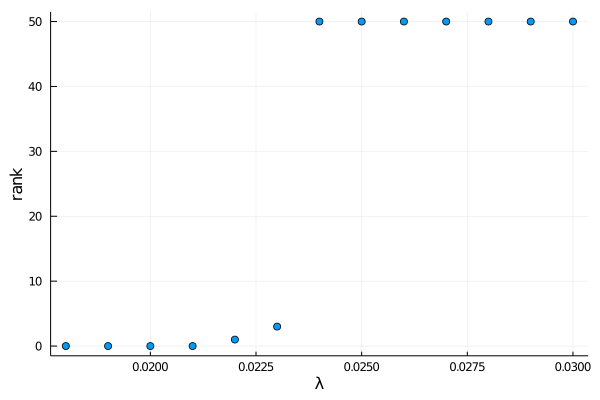

In [46]:
ranks = [t[2] for t in results]
plot(λs, ranks, seriestype = :scatter, xlabel = "λ", ylabel = "rank", legend = false)

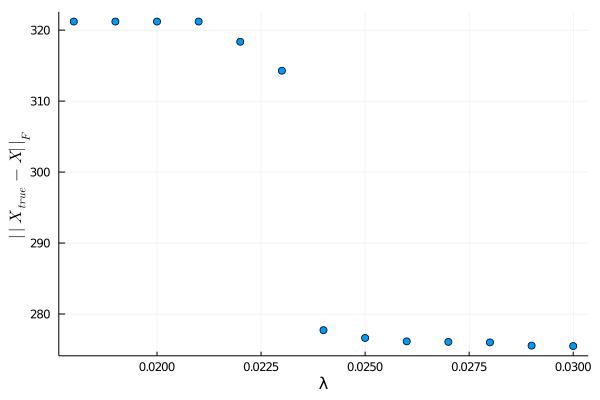

In [47]:
error = [t[3] for t in results]
plot(λs, error, seriestype = :scatter, xlabel = "λ", ylabel = L"||X_{true} - X||_F", legend = false)

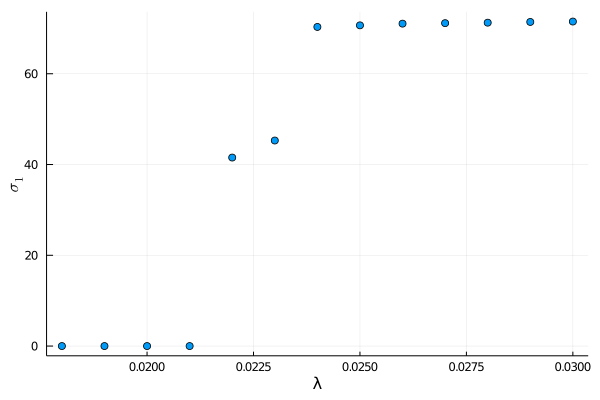

In [48]:
σs = [t[4] for t in results]
plot(λs, σs, seriestype = :scatter, xlabel = "λ", ylabel = L"\sigma_1", legend = false)

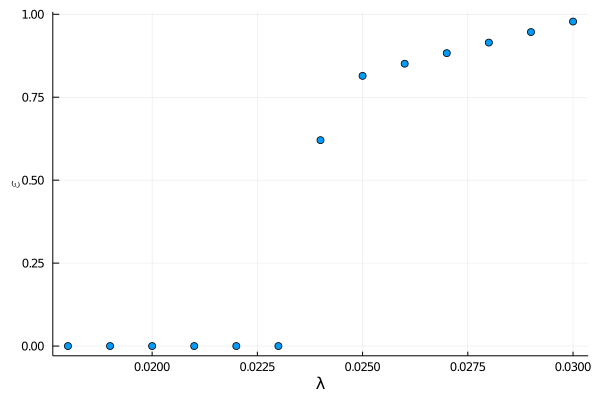

In [49]:
ϵs = [t[5] for t in results]
plot(λs, ϵs, seriestype = :scatter, xlabel = "λ", ylabel = L"\epsilon", legend = false)

In [50]:
λs = 0.022:0.0001:0.024
results = [vanilla_MatrixIRLS_for_PCA_with_CG(L₀, y, Φ, λ=λ, N = 100) for λ in λs];

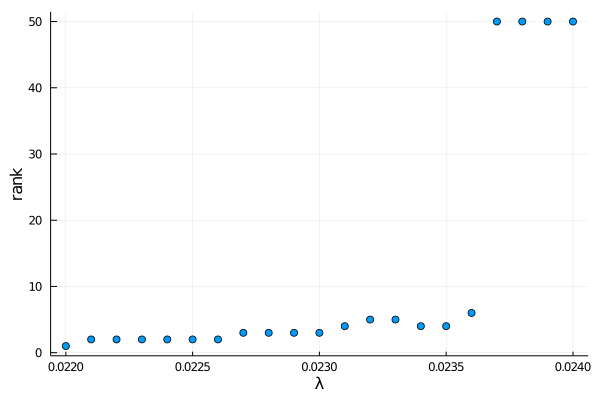

In [51]:
ranks = [t[2] for t in results]
plot(λs, ranks, seriestype = :scatter, xlabel = "λ", ylabel = "rank", legend = false)

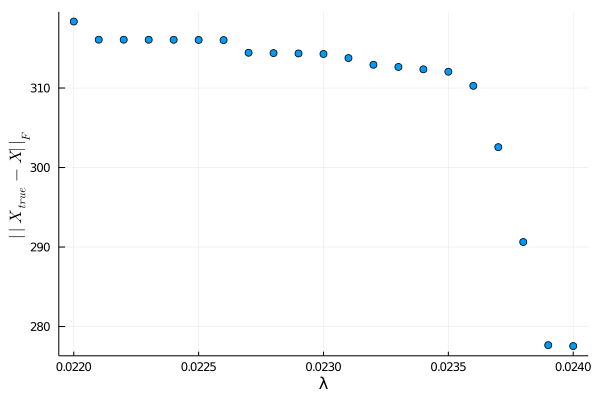

In [52]:
error = [t[3] for t in results]
plot(λs, error, seriestype = :scatter, xlabel = "λ", ylabel = L"||X_{true} - X||_F", legend = false)

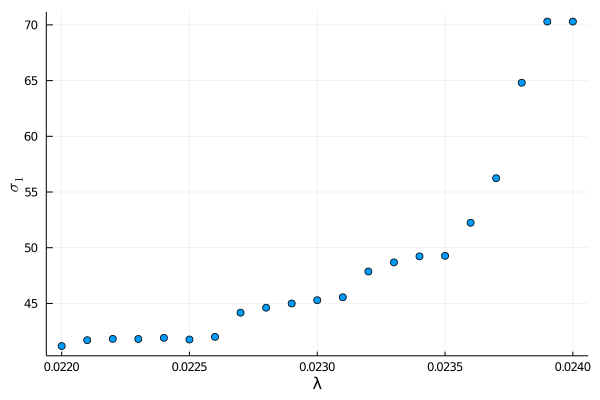

In [53]:
σs = [t[4] for t in results]
plot(λs, σs, seriestype = :scatter, xlabel = "λ", ylabel = L"\sigma_1", legend = false)

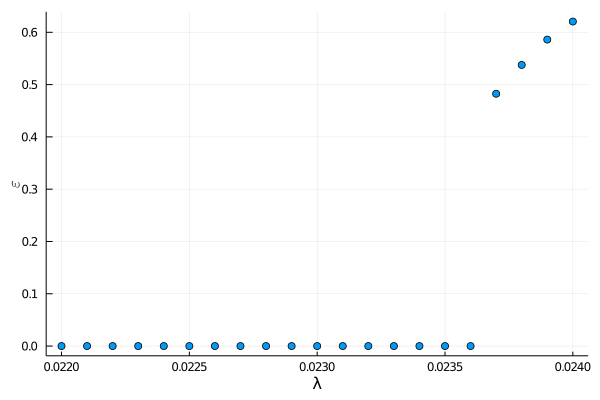

In [54]:
ϵs = [t[5] for t in results]
plot(λs, ϵs, seriestype = :scatter, xlabel = "λ", ylabel = L"\epsilon", legend = false)

# Robust Principal Component Analysis?
*by Emmanuel J. Candès, Xiaodong Li, Yi Ma, and John Wright*  
https://arxiv.org/pdf/0912.3599.pdf

#### 4.1 Exact recovery from varying fractions of error

We first verify the correct recovery phenomenon of Theorem 1.1 on randomly generated problems. We consider square matrices of varying dimension $n = 500, \ldots , 3000$. We generate a rank-$r$ matrix $L_0$ as a product $L_0 = XY^∗$ where $X$ and $Y$ are $n \times r$ matrices with entries independently sampled
from a $\mathcal{N}(0,1/n)$ distribution. $S_0$ is generated by choosing a support set $\Omega$ of size $k$ uniformly at random, and setting $S_0 = \mathcal{P}_\Omega E$, where $E$ is a matrix with independent Bernoulli $\pm 1$ entries. Table 1 (top) reports the results with $r = rank(L_0) = 0.05 \times n$ and $k = \Vert S_0 \Vert_0 = 0.05 \times n^2$. Table 1 (bottom) reports the results for a more challenging scenario, $rank(L_0) = 0.05 \times n$ and $k = 0.10 \times n^2$. In all cases, we set $\lambda = 1 \cdot \sqrt{n}$. Notice that in all cases, solving the convex PCP gives a result $(L, S)$ with the correct rank and sparsity. Moreover, the relative error $\frac{\Vert L - L_0 \Vert_F}{\Vert L_0 \Vert_F}$ is small, less than $10^{-5}$ in all examples considered.

<center><img src="table_1.png" /></center>

### Generate Data

_**Note:** In this notebook we deal only with PCA (simple matrix completion); therefore, there is no sparse component in the ground truth matrix._

In [10]:
L₀ = generateLowRankComponent_Candes(n, r, dType)
@show size(L₀)
@show rank(L₀);

size(L₀) = (50, 50)
rank(L₀) = 7


#### Sampling Mask ($\Phi$)

Using the earlier generated sampling mask

#### Subsampling The Ground Truth Matrix

In [11]:
y = Φ * L₀
@show rank(y);

rank(y) = 50


### Running The Reconstruction

In [12]:
@time vanilla_MatrixIRLS_for_PCA(L₀, y, Φ, N = 80, verbose = true);

k = 0,	rank(Xᵏ) = 44,	‖Xᴳᵀ - Xᵏ‖₂ =   0.044, σ₁ =   0.020, ϵᵏ =   0.011


LoadError: How should I calculate the solution of the constrained problem of arg minₓ ⟨X,Wᵏ⁻¹(X)⟩ s.t. Φ(X) = y with conjugate gradient?